In [17]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import sys

sys.path.append(r"E:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\libs")

from libs.utils import *

# I. Load và xử lý dữ liệu:

In [2]:
DATASET_PATH = r"E:\Learn Machine Learning\Project\Opinion Classifier\res\dataset\tf-idf-remv-stopwords.csv"

data : pd.DataFrame = read_dataset(DATASET_PATH, "csv", header=0)

data.head()

15:00:25 root INFO: Đang đọc dữ liệu từ file E:\Learn Machine Learning\Project\Opinion Classifier\res\dataset\tf-idf-remv-stopwords.csv ...
		at Line 330 [read_dataset() in utils.py, utils]
15:00:31 root INFO: Đọc thành công! 
		at Line 338 [read_dataset() in utils.py, utils]


,Unnamed: 0,thạc,666,tham_khảo,danh,gấp_bội,nhàg,ứng,gài,mặc_dù,...,nghìn,center,trượt_tín,bậc,tự_động,cmt,sứ_mệnh,live,địa_phương,label
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral


Loại bỏ cột đầu tiên do rõ ràng không cần thiết (chỉ chạy một lần):

In [3]:
data = data.drop(columns=data.columns.values[0], axis=1)
data.head()

,thạc,666,tham_khảo,danh,gấp_bội,nhàg,ứng,gài,mặc_dù,rộng_rãi,...,nghìn,center,trượt_tín,bậc,tự_động,cmt,sứ_mệnh,live,địa_phương,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral



Lọc các lớp có trong tập huấn luyện:

In [4]:
labels : list[str] = data["label"].unique().tolist()
labels.sort(reverse=True)
labels

['Positive', 'Neutral', 'Negative']

Thống kê số mẫu:

In [5]:
n_samples_classes = data["label"].value_counts().to_dict()
n_samples_classes

{'Positive': 1085, 'Neutral': 842, 'Negative': 569}

Thực hiện đánh trọng số cho các lớp theo công thức:

        class_weight = n_samples / (n_classes * n_samples_class_k)

, trong đó:
* `n_samples` là tổng số đối tượng tập huấn luyện. 
* `n_classes` là tổng số lớp. 
* `n_sample_class_k` là tổng số đối tượng tập huấn luyện thuộc lớp k.
* `class_weight` là trọng số của lớp k.


In [6]:
n_samples : int = len(data)
class_weight : dict[str, float] = {k : n_samples / (len(labels) * n_samples_classes.get(k)) for k in n_samples_classes}
class_weight

{'Positive': 0.7668202764976959,
 'Neutral': 0.9881235154394299,
 'Negative': 1.4622144112478033}

Phân chia tập dữ liệu thành tập huấn luyện và tập kiểm thử:

In [7]:
training_set, testing_set = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data["label"])

In [8]:
def draw_labels_rate_pie(y : pd.Series, title : str="Tỉ lệ nhãn tập dữ liệu", save_fig : bool = False):
    precent_rate = lambda sub , total : (sub / total) * 100
    labels = list(y.unique())
    labels.sort()
    labels_rate = [precent_rate(len(y[y == x]), len(y)) for x in labels]
    fig_labels_rate, ax = plt.subplots()
    ax.pie(labels_rate, labels=[str(len(y[y == x])) for x in labels], autopct='%1.2f%%', shadow=False)
    plt.title(title)
    plt.legend(loc="lower right", labels=labels)
    if save_fig:
        save_fig(IMAGES_PATH, "Labels Rate")    

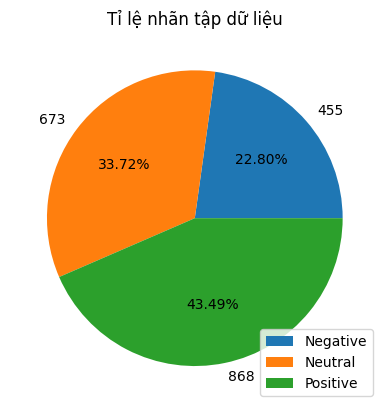

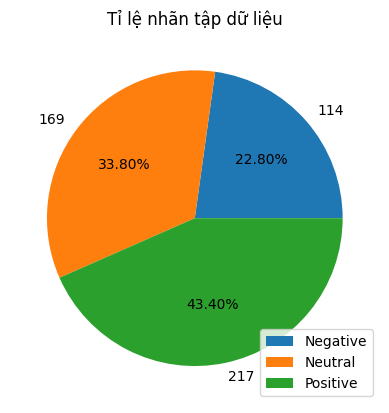

In [9]:
draw_labels_rate_pie(training_set["label"])

draw_labels_rate_pie(testing_set["label"])

# 2. Huấn luyện không sử dụng oversampling:

## 2.1. Phân chia dữ liệu:

In [10]:
X_train : pd.DataFrame = training_set.drop(columns="label", axis=1)
y_train : pd.Series = training_set["label"].copy()
X_testing : pd.DataFrame = testing_set.drop(columns="label", axis=1)
y_testing : pd.Series = testing_set["label"].copy()


Chuyển nhãn của tập huấn luyện sang dạng số (Thuận tiện cho tính toán)

In [11]:
y_train_encode = y_train.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))
y_train_encode.head()

604     2
2352    1
255     0
1972    0
2034    1
Name: label, dtype: int64

Tính toán trọng số của lớp cho từng lớp

In [12]:
y_encode_label = {label : i for i, label in enumerate(labels)}

class_weight = {y_encode_label.get(k) : class_weight.get(k) for k in class_weight}
class_weight

{0: 0.7668202764976959, 1: 0.9881235154394299, 2: 1.4622144112478033}

## 2.2. Huấn luyện mô hình:

Huấn luyện thử các mô hình đặc trưng

15:02:41 root INFO: Saving figure 'RemoveStopwordLogisticRegressionTFIDFDefault' ...
		at Line 62 [save_fig() in utils.py, utils]
15:02:41 root INFO: Saved figure 'RemoveStopwordLogisticRegressionTFIDFDefault'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\RemoveStopwordLogisticRegressionTFIDFDefault.png
		at Line 66 [save_fig() in utils.py, utils]


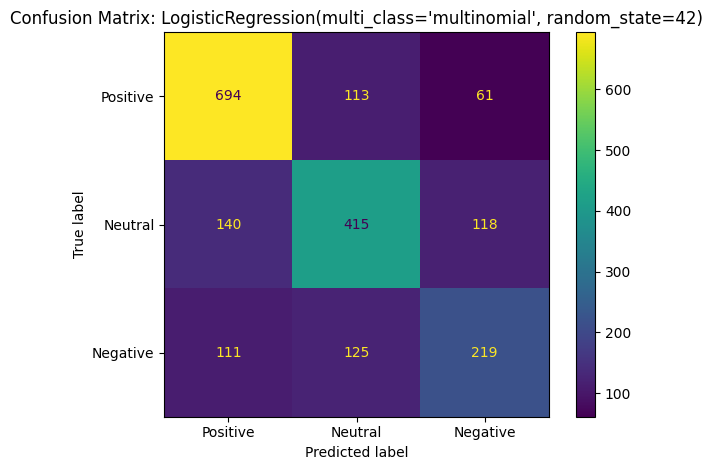

15:02:42 root INFO: 
Average: None
Precision:	[0.73439153 0.63552833 0.55025126]
Recall:		[0.79953917 0.6166419  0.48131868]
--> F1-score:	[0.76558191 0.62594268 0.51348183]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.73439153, 0.63552833, 0.55025126]),
 array([0.79953917, 0.6166419 , 0.48131868]),
 array([0.76558191, 0.62594268, 0.51348183]))

In [13]:
lgt_reg = LogisticRegression(random_state=42, multi_class="multinomial", fit_intercept=True)

lgt_reg.fit(X_train, y_train_encode)

measure_score(lgt_reg, X_train, y_train_encode, average=None, labels=labels, cv=10, fig_title="RemoveStopwordLogisticRegressionTFIDFDefault")


23:39:25 root INFO: Saving figure 'RemoveStopwordLogisticRegressionTFIDFDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
23:39:25 root INFO: Saved figure 'RemoveStopwordLogisticRegressionTFIDFDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\RemoveStopwordLogisticRegressionTFIDFDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


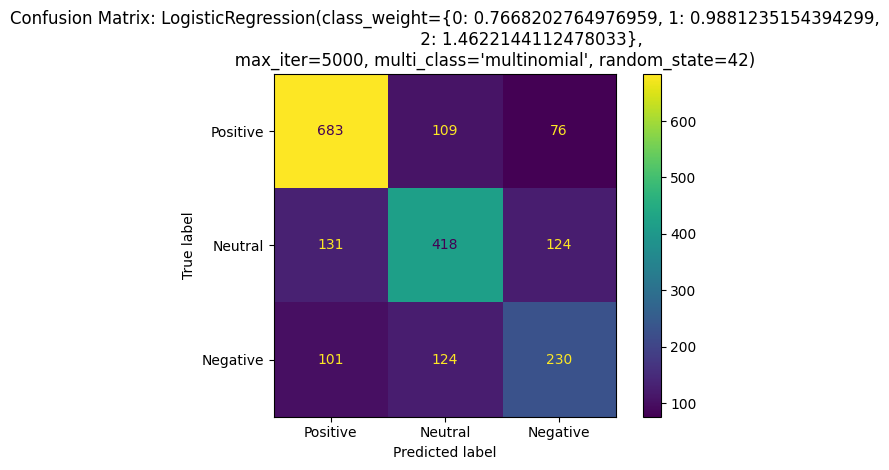

23:39:26 root INFO: 
Average: None
Precision:	[0.74644809 0.64208909 0.53488372]
Recall:		[0.78686636 0.62109955 0.50549451]
--> F1-score:	[0.76612451 0.63141994 0.51977401]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.74644809, 0.64208909, 0.53488372]),
 array([0.78686636, 0.62109955, 0.50549451]),
 array([0.76612451, 0.63141994, 0.51977401]))

In [14]:
lgt_reg = LogisticRegression(
    random_state=42,
    multi_class="multinomial",
    fit_intercept=True,
    class_weight=class_weight,
    max_iter=5000
)

# lgt_reg.fit(X_train, y_train_encode)

measure_score(lgt_reg, X_train, y_train_encode, average=None, labels=labels, cv=10, fig_title="RemoveStopwordLogisticRegressionTFIDFDefault2")

Tinh chỉnh tham số mô hình khi no-scaler

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s finished
16:08:10 root INFO: Best esitmator params: {'C': 0.006723357536499335, 'penalty': 'l2'}
		at Line 28 [<module>() in 2135894922.py, 2135894922]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Pa

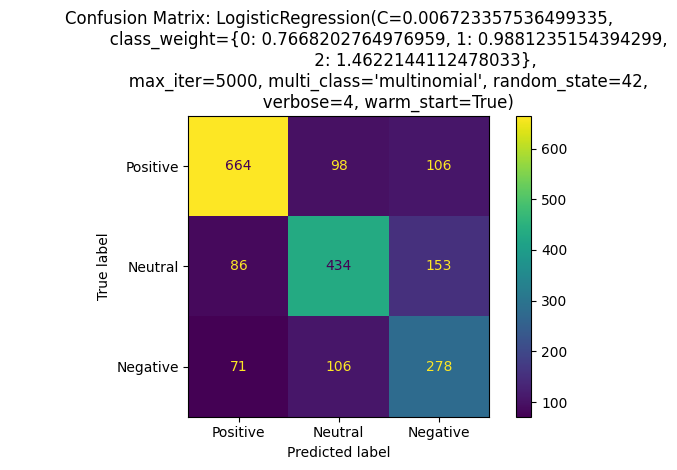

16:09:13 root INFO: 
Average: None
Precision:	[0.80876979 0.68025078 0.51769088]
Recall:		[0.76497696 0.6448737  0.61098901]
--> F1-score:	[0.78626406 0.66209001 0.56048387]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.80876979, 0.68025078, 0.51769088]),
 array([0.76497696, 0.6448737 , 0.61098901]),
 array([0.78626406, 0.66209001, 0.56048387]))

In [14]:
lgt_reg_params = {
    "C" : np.logspace(-3, 3, 30),
    "penalty" : ['l2', None],
    # "max_iter" : [100, 500, 1000, 2000, 5000],
    # "tol" : [1e-6, 1e-5, 1e-4]
}

lgt_reg_grid = GridSearchCV(
    LogisticRegression(
        random_state=42,
        multi_class="multinomial",
        fit_intercept=True,
        class_weight=class_weight,
        max_iter=5000,
        verbose=4,
        warm_start=True,
    ),
    lgt_reg_params,
    scoring="f1_weighted",
    n_jobs=-1,
    cv=5,
    verbose=4,
    return_train_score=True,
)

lgt_reg_grid.fit(X_train, y_train_encode)

logging.info("Best esitmator params: " + str(lgt_reg_grid.best_params_))

measure_score(lgt_reg_grid.best_estimator_, X_train, y_train_encode, None, labels=labels, cv=10, fig_title="RemoveStopwordLogisticRegressionGridSearch")

In [15]:
save_model("remove_stopword_logistic_regression.pkl", lgt_reg_grid.best_estimator_)

16:09:40 root INFO: Đang lưu lại mô hình...
		at Line 88 [save_model() in utils.py, utils]
16:09:40 root INFO: Lưu thành công!
		at Line 92 [save_model() in utils.py, utils]


Kiểm thử mô hình với tập kiểm thử :

In [18]:
y_test_encode = y_testing.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))

y_test_pred = lgt_reg_grid.best_estimator_.predict(X_testing)

print(classification_report(y_test_encode, y_test_pred))


              precision    recall  f1-score   support

           0       0.78      0.73      0.76       217
           1       0.66      0.64      0.65       169
           2       0.53      0.61      0.57       114

    accuracy                           0.67       500
   macro avg       0.66      0.66      0.66       500
weighted avg       0.68      0.67      0.68       500



# 3. Sử dụng oversampling để huấn luyện:

Sử dụng over-sample để khắc phục tình trạng imbalance của lớp:

In [20]:
training_set.head(10)

,thạc,666,tham_khảo,danh,gấp_bội,nhàg,ứng,gài,mặc_dù,rộng_rãi,...,nghìn,center,trượt_tín,bậc,tự_động,cmt,sứ_mệnh,live,địa_phương,label
604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Negative
2352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Neutral
255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.436551,0.0,0.0,Positive
1972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
2034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Neutral
1925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive


Tách và tính độ lớn các mẫu của từng lớp riêng biệt:

In [23]:
training_set_positive : pd.DataFrame = training_set[training_set["label"] == "Positive"]
training_set_negative : pd.DataFrame = training_set[training_set["label"] == "Negative"]
training_set_neutral : pd.DataFrame = training_set[training_set["label"] == "Neutral"]

In [24]:
print(len(training_set_positive))
print(len(training_set_negative))
print(len(training_set_neutral))

868
455
673


chọn ra các mẫu ngẫu nhiên trong các tập negative và neutral, sau đó nối thêm vào tập ban đầu để mở rộng thêm tập negative và tập neutral

In [25]:
training_set_negative_ovs = training_set_negative.sample(len(training_set_positive), replace=True)
training_set_neutral_ovs = training_set_neutral.sample(len(training_set_positive), replace=True)


In [26]:
print(len(training_set_positive))
print(len(training_set_negative_ovs))
print(len(training_set_neutral_ovs))

868
868
868


Nối ba tập đã oversample lại và tạo thành tập hoàn chỉnh

In [27]:
training_set_ovs = pd.concat([training_set_positive, training_set_negative_ovs, training_set_neutral_ovs])

In [28]:
training_set_ovs.shape

(2604, 5345)

In [29]:
X_train_ovs : pd.DataFrame = training_set_ovs.drop(columns="label", axis=1)
y_train_ovs : pd.Series = training_set_ovs["label"].copy()

In [30]:
y_train_encode_ovs = y_train_ovs.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))

y_train_encode_ovs.value_counts()

0    868
2    868
1    868
Name: label, dtype: int64

01:38:53 root INFO: Saving figure 'LogisticRegressionOversample' ...
		at Line 62 [save_fig() in utils.py, utils]
01:38:54 root INFO: Saved figure 'LogisticRegressionOversample'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LogisticRegressionOversample.png
		at Line 66 [save_fig() in utils.py, utils]


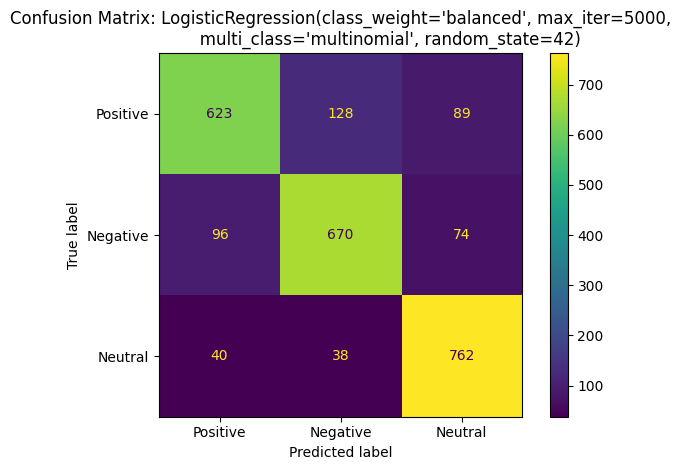

01:38:54 root INFO: 
Average: None
Precision:	[0.82081686 0.80143541 0.82378378]
Recall:		[0.74166667 0.79761905 0.90714286]
--> F1-score:	[0.77923702 0.79952267 0.86345609]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.82081686, 0.80143541, 0.82378378]),
 array([0.74166667, 0.79761905, 0.90714286]),
 array([0.77923702, 0.79952267, 0.86345609]))

In [ ]:
lgt_reg = LogisticRegression(
    random_state=42,
    multi_class="multinomial",
    fit_intercept=True,
    class_weight="balanced",
    max_iter=5000,
)

lgt_reg.fit(X_train_resample, y_train_encode_resample)

measure_score(lgt_reg, X_train_resample, y_train_encode_resample, average=None, labels=["Positive", "Negative", "Neutral"], cv=10, fig_title="LogisticRegressionOversample")

Wao! Mô hình sau khi sử dụng oversampling cho ra một kết quả chính xác cao hơn hẳn! Tuy nhiên, có thể mô hình đang bị overfitting dữ liệu nên nó sẽ thể hiện kém khi gặp tập dữ liệu test.

In [ ]:
lgt_reg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Tinh chỉnh mô hình trên

In [31]:
lgt_reg_params = {
    "C" : np.logspace(-3, 3, 30),
    "penalty" : ['l2', None],
    # "max_iter" : [100, 500, 1000, 2000, 5000],
    # "tol" : [1e-6, 1e-5, 1e-4]
}

lgt_reg_grid = GridSearchCV(
    LogisticRegression(
        random_state=42,
        multi_class="multinomial",
        fit_intercept=True,
        max_iter=5000,
        verbose=4,
        warm_start=True,
    ),
    lgt_reg_params,
    scoring="f1_weighted",
    n_jobs=-1,
    cv=5,
    verbose=4,
    return_train_score=True,
)

lgt_reg_grid.fit(X_train_ovs, y_train_encode_ovs)

logging.info("Best esitmator params: " + str(lgt_reg_grid.best_params_))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s finished
17:03:37 root INFO: Best esitmator params: {'C': 0.3039195382313198, 'penalty': 'l2'}
		at Line 28 [<module>() in 4052079766.py, 4052079766]


TypeError: can only concatenate str (not "numpy.float64") to str

In [32]:
lgt_reg_grid.best_estimator_

LogisticRegression(C=0.3039195382313198,
                   class_weight={0: 0.7668202764976959, 1: 0.9881235154394299,
                                 2: 1.4622144112478033},
                   max_iter=5000, multi_class='multinomial', random_state=42,
                   verbose=4, warm_start=True)

In [33]:
logging.info(f"Score: {lgt_reg_grid.best_score_}")

17:04:51 root INFO: Score: 0.8615710707383629
		at Line 1 [<module>() in 2159969777.py, 2159969777]


Kiểm thử trên tập kiểm thử:

In [34]:
y_test_encode = y_testing.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))

y_test_pred = lgt_reg_grid.best_estimator_.predict(X_testing)

print(classification_report(y_test_encode, y_test_pred))


              precision    recall  f1-score   support

           0       0.72      0.75      0.73       217
           1       0.68      0.60      0.64       169
           2       0.46      0.51      0.49       114

    accuracy                           0.64       500
   macro avg       0.62      0.62      0.62       500
weighted avg       0.65      0.64      0.64       500



In [35]:
save_model("ovs_not_remv_stopword_logistic_regression.pkl", lgt_reg_grid.best_estimator_)

02:06:00 root INFO: Đang lưu lại mô hình...
		at Line 88 [save_model() in utils.py, utils]
02:06:00 root INFO: Lưu thành công!
		at Line 92 [save_model() in utils.py, utils]
